## Importing Essential Modules

In [ ]:
import os
import shutil
import random
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization,Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [ ]:
initial_path = '/content/drive/MyDrive/photos'

# Define the new top-level directory names
directories = ['train', 'val', 'test']

# Define the subdirectory names for each top-level directory
subdirectories = ['daytime','nighttime','sunrise']

# Define the proportions for train, validation, and test sets
props = [0.9, 0.05, 0.05]

# Loop over the top-level directories and subdirectories, and create the corresponding directories
for directory in directories:
    for subdirectory in subdirectories:
        path = os.path.join(initial_path, subdirectory)
        files = os.listdir(path)
        random.shuffle(files)
        total = len(files)
        train_end = int(total * props[0])
        val_end = train_end + int(total * props[1])
        if directory == 'train':
            new_files = files[:train_end]
        elif directory == 'val':
            new_files = files[train_end:val_end]
        else:
            new_files = files[val_end:]
        new_path = os.path.join(directory, subdirectory)
        os.makedirs(new_path, exist_ok=True)
        for file in new_files:
            old_file_path = os.path.join(path, file)
            new_file_path = os.path.join(new_path, file)
            shutil.copy(old_file_path, new_file_path)

## Preparing Data For Training

In [ ]:
# Define the directories for the train, validation, and test sets
train_dir = 'train'
val_dir = 'val'

# Define the image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 32
# Define the data generators for the train, validation, and test sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb')

Found 2403 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


## Building Model Architecture

In [ ]:
# Defining the architecture
model = Sequential()

model.add(Conv2D(64,(3,3),padding = "same", activation = "relu", input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation = "relu",padding = "same"))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation = "relu",padding = "same"))
model.add(MaxPool2D(2,2))
    
model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), activation = "relu",padding = "same"))
model.add(MaxPool2D(2,2))
  
model.add(Flatten())
    
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))

model.add(Dense(3, activation='softmax'))
    

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/10
75/75 [==============================] - 47s 619ms/step - loss: 0.3726 - accuracy: 0.8722 - val_loss: 0.3214 - val_accuracy: 0.8750
Epoch 2/10
75/75 [==============================] - 46s 612ms/step - loss: 0.3728 - accuracy: 0.8697 - val_loss: 0.3785 - val_accuracy: 0.8438
Epoch 3/10
75/75 [==============================] - 46s 608ms/step - loss: 0.3486 - accuracy: 0.8756 - val_loss: 0.4324 - val_accuracy: 0.8359
Epoch 4/10
75/75 [==============================] - 46s 608ms/step - loss: 0.3321 - accuracy: 0.8857 - val_loss: 0.3012 - val_accuracy: 0.9141
Epoch 5/10
75/75 [==============================] - 46s 604ms/step - loss: 0.3416 - accuracy: 0.8811 - val_loss: 0.2891 - val_accuracy: 0.9062
Epoch 6/10
75/75 [==============================] - 45s 597ms/step - loss: 0.3335 - accuracy: 0.8815 - val_loss: 0.2901 - val_accuracy: 0.8984
Epoch 7/10
75/75 [==============================] - 46s 604ms/step - loss: 0.3245 - accuracy: 0.8794 - val_loss: 0.2404 - val_accuracy: 0.8984

In [ ]:
model.save('final_model.h5')

**Test generator and Making predictions**

In [ ]:
# Define a dictionary to convert label indices to class names
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

# Use the trained model to predict labels for the test images
test_dir = "/content/test"
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,  # Set batch size to 1 to get individual images
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
predictions = model.predict(test_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [class_names[label] for label in predicted_labels]

# Get the true labels of the test images
true_labels = test_generator.classes
true_labels = [class_names[label] for label in true_labels]

Found 135 images belonging to 3 classes.
135/135 [==============================] - 1s 7ms/step


# results


In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


135/135 [==============================] - 1s 10ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


## Loss and Accuracy Score

In [ ]:
test_loss, test_accuracy = model.evaluate_generator(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)



<ipython-input-24-37553687617d>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator)


Test Loss: 0.33396071195602417
Test Accuracy: 0.8592592477798462


## Classification Report

In [ ]:
class_names = list(train_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     daytime       0.93      0.80      0.86        46
   nighttime       0.94      0.77      0.85        39
     sunrise       0.78      0.98      0.87        50

    accuracy                           0.86       135
   macro avg       0.88      0.85      0.86       135
weighted avg       0.87      0.86      0.86       135



## Confusion Matrix

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[37  2  7]
 [ 2 30  7]
 [ 1  0 49]]


## Loss and Accuracy Plots

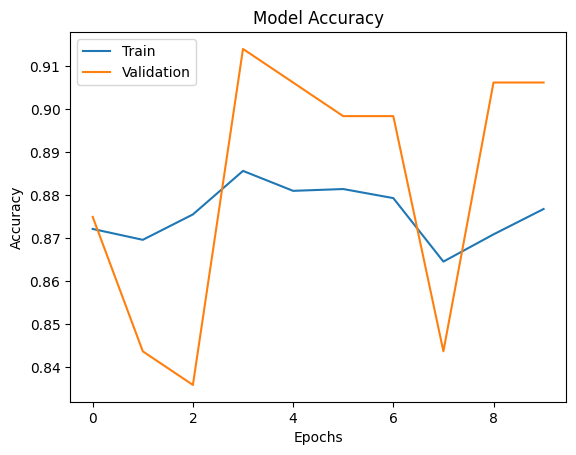

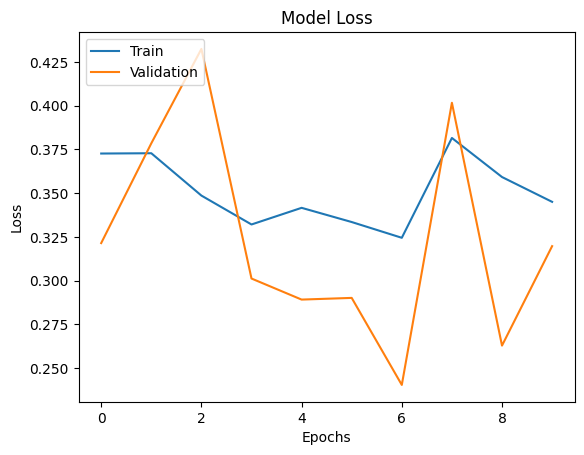

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
